In [1]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 KB 708.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.0/186.0 KB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 142.9 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.9/507.9 KB 102.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 KB 78.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 KB 112.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.1/146.1 KB 132.3 kB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.17.9-py3-none-any.whl size=139000 sha256=19d370fefe9310262b4f087ee0c3e0c7d9ec52e3ebce756ee134f1d35be697ea
  St

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Input
from tensorflow.keras.utils import plot_model

In [4]:
ms = yf.download('MSFT',start='2012-01-01',end='2023-12-31',progress=False)

YF.download() has changed argument auto_adjust default to True


In [5]:
ms.head()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2012-01-03,21.120090,21.269989,20.820290,20.946521,64731500
2012-01-04,21.617132,21.672358,21.127986,21.159543,80516100
2012-01-05,21.838039,21.877486,21.530351,21.601355,56081400
2012-01-06,22.177290,22.240406,21.719701,21.719701,99455500
2012-01-09,21.885376,22.169397,21.869597,22.129949,59706800


In [6]:
ms[:"2021"].Close.values.reshape(-1,1).shape

(2517, 1)

In [7]:
train = ms[:"2021"].Close.values.reshape(-1,1)
test = ms["2022":].Close.values.reshape(-1,1)

In [8]:
train.shape,test.shape

((2517, 1), (501, 1))

In [9]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [10]:
def convert_data_extra(data,x_step,y_step):
  X,Y = [],[]
  for i in range(len(data)-x_step-y_step+1):
    d=i+x_step

    X.append(data[i:d])
    Y.append(data[d:d+y_step])

  return np.array(X),np.array(Y)

In [11]:
x_step=10
y_step=1
trainX,trainY=convert_data_extra(train,x_step,y_step)
testX,testY=convert_data_extra(test,x_step,y_step)
trainX.shape,testX.shape

((2507, 10, 1), (491, 10, 1))

## Model1:

In [12]:
model = Sequential()
model.add(LSTM(units=64,activation='tanh',input_shape=(10,1),return_sequences=True))
model.add(LSTM(units=64,activation='tanh',input_shape=(None,1),return_sequences=True))
model.add(LSTM(units=64,activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

2025-02-15 22:26:17.183326: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-02-15 22:26:17.183371: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-15 22:26:17.183402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (milad-HP): /proc/driver/nvidia/version does not exist
2025-02-15 22:26:17.183754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(trainX,trainY,epochs=20,batch_size=16)

Epoch 1/20
157/157 [==============================] - 12s 21ms/step - loss: 0.0044
Epoch 2/20
157/157 [==============================] - 4s 23ms/step - loss: 1.9370e-04
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 1.8253e-04
Epoch 4/20
157/157 [==============================] - 4s 23ms/step - loss: 2.2157e-04
Epoch 5/20
157/157 [==============================] - 3s 22ms/step - loss: 2.4082e-04
Epoch 6/20
157/157 [==============================] - 3s 22ms/step - loss: 2.4589e-04
Epoch 7/20
157/157 [==============================] - 4s 23ms/step - loss: 2.4449e-04
Epoch 8/20
157/157 [==============================] - 3s 21ms/step - loss: 2.0592e-04
Epoch 9/20
157/157 [==============================] - 3s 21ms/step - loss: 1.9703e-04
Epoch 10/20
157/157 [==============================] - 4s 25ms/step - loss: 2.4891e-04
Epoch 11/20
157/157 [==============================] - 4s 24ms/step - loss: 2.5061e-04
Epoch 12/20
157/157 [==============================] - 

In [22]:
score = model.evaluate(trainX,trainY)
print('train score',score)
score = model.evaluate(testX,testY)
print('test score',score)

79/79 [==============================] - 1s 11ms/step - loss: 2.4507e-04
train score 0.00024507255875505507
16/16 [==============================] - 0s 10ms/step - loss: 0.0018
test score 0.0017534916987642646


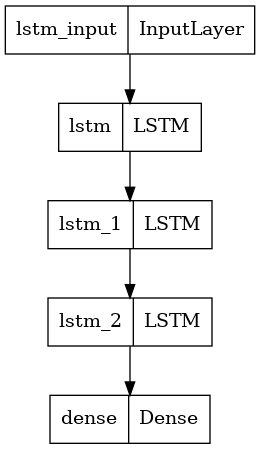

In [24]:
plot_model(model)

In [25]:
train_preds = model.predict(trainX)
test_preds = model.predict(testX)

16/16 [==============================] - 0s 10ms/step


In [26]:
predicted=np.concatenate((train_preds,test_preds),axis=0)

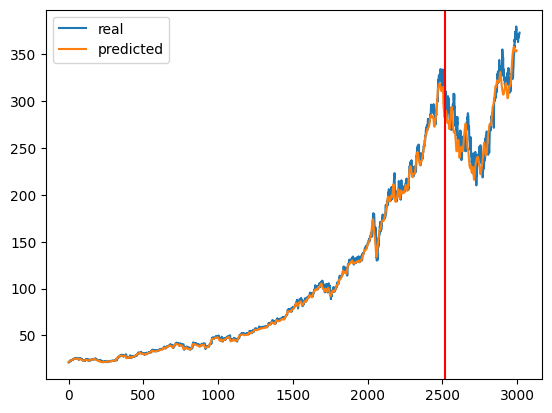

In [27]:
plt.plot(ms.Close.values,label='real')
plt.plot(scaler.inverse_transform(predicted),label='predicted')
plt.axvline(x=len(train),c='r')
plt.legend()
plt.show()

## Model2:

In [12]:
model2 = Sequential()
model2.add(Input(shape = trainX.shape[1:]))
model2.add(Bidirectional(LSTM(64,return_sequences=True)))
model2.add(Bidirectional(LSTM(64,return_sequences=False)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 128)          33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [14]:
history2 = model2.fit(trainX,trainY,epochs=20,batch_size=16)

Epoch 1/20
157/157 [==============================] - 4s 23ms/step - loss: 4.8571e-04
Epoch 2/20
157/157 [==============================] - 4s 24ms/step - loss: 1.3385e-04
Epoch 3/20
157/157 [==============================] - 4s 26ms/step - loss: 1.4260e-04
Epoch 4/20
157/157 [==============================] - 4s 28ms/step - loss: 1.3573e-04
Epoch 5/20
157/157 [==============================] - 4s 26ms/step - loss: 1.3992e-04
Epoch 6/20
157/157 [==============================] - 4s 27ms/step - loss: 1.7528e-04
Epoch 7/20
157/157 [==============================] - 3s 21ms/step - loss: 2.3595e-04
Epoch 8/20
157/157 [==============================] - 4s 23ms/step - loss: 1.6292e-04
Epoch 9/20
157/157 [==============================] - 4s 23ms/step - loss: 1.5688e-04
Epoch 10/20
157/157 [==============================] - 4s 24ms/step - loss: 1.5056e-04
Epoch 11/20
157/157 [==============================] - 4s 24ms/step - loss: 1.3166e-04
Epoch 12/20
157/157 [==============================]

In [15]:
train_preds = model2.predict(trainX)
test_preds = model2.predict(testX)
predicted = np.concatenate((train_preds,test_preds),axis=0)

16/16 [==============================] - 0s 11ms/step


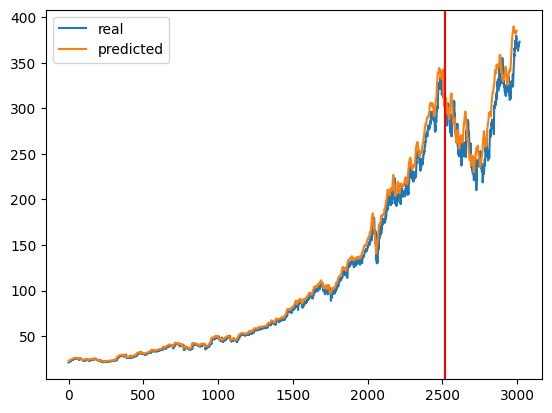

In [16]:
plt.plot(ms.Close.values,label='real')
plt.plot(scaler.inverse_transform(predicted),label='predicted')
plt.axvline(x = len(train),c='r')
plt.legend()
plt.show()